## Prerequisites

## Import packages

In [1]:
'''Import all necessary packages...
pandas: data munging, 
numpy: store the images, 
cv2: image manipulation (resize, grayscale, blur, binarization, and select Region Of Interest (ROI)
contours: manage selected ROI
%matplotlib for making any plots show up inside of this notebook, here mainly to show up images
pytesseract: extract text in image to string with OCR (Optical Character Recognition)
shutil and os: get path and manage files 
We will discuss each of these packages as we use them for our analysis'''

import pandas as pd
import numpy as np
import cv2
from imutils import contours
from matplotlib import pyplot as plt
import pytesseract
import shutil
import os
%matplotlib inline

# below line to tell pytesseract that we will use tesseract in this directory
pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/Cellar/tesseract/5.2.0/bin/tesseract'

## I. Define helper functions that we will use later

In [2]:
'''
For a grayscale image, we want to know whether it is black text over a white backgroud, 
or white text over black background
When using pytesseract to extract text from image, image must be black text over a white backgroud
The method to judge is that if we have more white pixel than black pixel, then it is white background;
otherwise, it is black backgroud
'''
def isWhiteBackground(image):
    numOfwhitePixel, numOfBlackPixel = 0, 0
    for x in range(len(image)):
        for y in range(len(image[0])):
            numOfwhitePixel += image[x][y]==255
            numOfBlackPixel += image[x][y]==0
    return numOfwhitePixel >= numOfBlackPixel


'''
When we select ROI from images, we want to know whether they contains the letter or number inside. 
A filter here is to assume that all letters or numbers (in black pixel) only take 30% - 80% of the total image space 
'''
def isValidROI(roi):
    numOfwhitePixel, numOfBlackPixel = 0, 0
    for x in range(len(roi)):
        for y in range(len(roi[0])):
            numOfwhitePixel += roi[x][y]==255
            numOfBlackPixel += roi[x][y]==0
    totalNumOfPixel = numOfBlackPixel + numOfwhitePixel
    return numOfBlackPixel/(totalNumOfPixel) > 0.3 and numOfBlackPixel/(totalNumOfPixel) < 0.8

'''
Remove all the files and sub-directories of a directory
'''
def clearContentsInDirectory(folder):
    if os.path.exists(folder):
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))
   
'''
Assign the order for ROIs in the image, which can be used to sort later
'''
def get_contour_precedence(contour, cols):
    tolerance_factor = 23
    c, r, w, h = cv2.boundingRect(contour)
    return ((c // tolerance_factor) * tolerance_factor) * cols + r

## II. Define the global parameters

In [3]:
'''
Set up configrations for image clip, image resize target:
we will extract the range between xTop to xBottom, yLeft to yRight of an image. 
This is to remove the state name and other unrelated infomation in a plate image, 
as the plate number are always in the center of an image

Also we will resize all the clipped images to size (targetX, targetY) to unify the analyze, the reason is that
we may have different size of plate images at the beginning, and we don't want to make the image size a model factor
'''

xTop = 0.28
xBottom = 0.88
yLeft = 0.05
yRight = 0.95

targetX, targetY = 300, 1000

## III. Define the main function

In [4]:
'''
This function will take a plate image path and generate the string of recognized plate number
Paramters:
    imgPath: a string of image path
    guassianX and guassianY: the pixel size for x and y direction when doing Guassian blur for image
                             Default values are set as (7, 7) as it gives best model accuracy. 
    useROI: If set as False, function will read the plate number directly from preprocessed 
            plate image as a whole using Pytesseract;
            if set as True, function will select a series of ROI (each ROI will only contain one letter or number), 
            recognize the single letter or number for each ROI, and finally combine them as the final plate number.  
'''

def recognizePlateNumber(imgPath, gaussianX=7, gaussianY=7, useROI=False):
    ## read imageId, generate temp roi folder to store generated ROIs with this image
    basePath = os.path.dirname(os.path.dirname(os.path.dirname(imgPath)))
    imageId = os.path.basename(imgPath).split(".")[0] 
    state = os.path.dirname(imgPath).split("/")[-1]

    ## read image, convert to gray scale (pixel value range: [0, 255]), and resize image
    img = cv2.imread(imgPath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imageX, imageY = gray.shape
    gray = cv2.resize(gray, (targetY,targetX), interpolation = cv2.INTER_CUBIC)
    grayX, grayY = gray.shape

    ## select from gray to remove state and other unnecessary info by choosing the center area of this image
    gray = gray[int(xTop*grayX):int(xBottom*grayX), int(yLeft*grayY):int(yRight*grayY)]

    ## get blurred image and binarize image
    ## thresh here will be binarized image, which only have white pixel (value as 255) and black pixel (value as 0)
    blur = cv2.GaussianBlur(gray,(gaussianX,gaussianY),0)
    ret, thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    ## if image is not black text over white background, flip it
    if not isWhiteBackground(thresh):
        thresh = 255 - thresh

    ## sometimes we found that for pytesseract, it is easier to recoginze text if the text are not close to edge
    ## therefore, we pad white pixels around the current thresh image to make the text not close to any edge
    threshX, threshY = thresh.shape
    extendedThresh = np.full((2*threshX, 2*threshY), 255, dtype="uint8")
    extendedThresh[threshX//2:threshX//2+threshX, threshY//2:threshY//2+threshY] = thresh
    
    ## initialize plate number as empty string
    plate = ""
    
    ## reading from the extendedThresh image as a whole using pytesseract
    ## We only allow the recognized char as capital letter or numbers, therefore adding whitelist here.
    ## --psm 13 and --oem 3 are choosen based on this docs: https://muthu.co/all-tesseract-ocr-options/
    ## result returned from image_to_string method always contains "\n\x0c" at the end, 
    ## therefore, we only extract the text before "\n"
    text = pytesseract.image_to_string(extendedThresh, config = "--psm 13 --oem 3 -c tessedit_char_whitelist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'").split("\n")
    if len(text)>1:
        plate = text[0]
    
    ## If useROI is set True, select ROIs and attempt reading from the selected ROI
    if useROI:
        print("Start to use ROI method")
        
        ## re-initialize plate number as empty string
        plate = ""
        
        ## create directory (folders) to save the selected ROI images. 
        ## Each image will have its own corresponding ROI folder
        generatedROIBasePath = basePath+"/generatedROI/"+state
        if not os.path.exists(os.path.dirname(generatedROIBasePath)):
            os.mkdir(os.path.dirname(generatedROIBasePath))
        if not os.path.exists(generatedROIBasePath):
            os.mkdir(generatedROIBasePath)
        generatedROIPath = generatedROIBasePath+"/"+imageId
        if not os.path.exists(generatedROIPath):
            os.mkdir(generatedROIPath)
        ## if any ROIs are in the folder from previous runs, clean them
        clearContentsInDirectory(generatedROIPath)
        
        ## standard steps to select ROIs from an image using opencv findContours method
        mask = np.zeros(extendedThresh.shape, dtype=np.uint8)
        cnts = cv2.findContours(extendedThresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        ## cnts (contours) are sorted from left to right
        (cnts, _) = contours.sort_contours(cnts, method="left-to-right")
        cnts = list(cnts)
        ## further sort contours if two contours are aligned vertically with similar horizontal position. 
        ## Under this case, upper image is placed first
        cnts.sort(key=lambda x:get_contour_precedence(x, extendedThresh.shape[1]))
        ## record how many ROIs we will select
        ROI_number = 0
        for c in cnts:
            area = cv2.contourArea(c)
            x,y,w,h = cv2.boundingRect(c)
            ## we don't want to select too small ROI (contour), as they don't contain any letter or number if too small
            ## similar, if too large, it may contain more than 1 letter or number, we should discard those as well.
            if w>30 and h>30 and area<150000:
                ## select ROI
                ROI =  extendedThresh[y:y+h, x:x+w]
                ## ensure this ROI contains letter or number, not other special char
                if isValidROI(ROI):
                    cv2.drawContours(mask, [c], -1, (255,255,255), -1)
                    ## save to folder
                    cv2.imwrite(generatedROIPath + "/ROI_{}.png".format(ROI_number), ROI)
                    ROI_number += 1

        ## for each ROI, we also resize them to a standard size
        targetRoiX, targetRoiY = 80,50
        ## loop each ROI
        for i in range(ROI_number):
            ## read ROI from previously saved folder
            roi = cv2.imread(generatedROIPath+ "/ROI_{}.png".format(i))
            ## make sure it is grayscale
            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            roiX, roiY = roi.shape
            ## similarly as we did before, pad white pixel around the image to make the image not close to edge
            extendedRoi = np.full((int(1.5*roiX), int(1.5*roiY)), 255, dtype="uint8")
            extendedRoi[roiX//4:roiX//4+roiX, roiY//4:roiY//4+roiY] = roi
            extendedRoiX, extendedRoiY = extendedRoi.shape
            extendedRoiResize = cv2.resize(extendedRoi, (targetRoiY, targetRoiX), interpolation = cv2.INTER_CUBIC)
            ## read single letter or number from this ROI
            text = pytesseract.image_to_string(extendedRoiResize,lang='eng', config = "--psm 13 --oem 3 -c tessedit_char_whitelist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'")
            ## if test is not empty, add to plate number
            if len(text)>1:
                plate = plate + text[0]
    
    print("Plate is: " + plate)
    return plate

## IV. Run the model and compare the accuracy

In [5]:
'''
specify the image base path. Plate images are saved in result/data/Washington folder
waPlates are the pre-created csv file which contains the correct plate number for each plate. 
We will use it to estimate model accuracy
'''

scriptPath = %pwd
basePath = scriptPath + "/result"
platesData = pd.read_csv(basePath + "/allData.csv")
waPlates = platesData.loc[platesData.State=="Washington",["State", "Image", "PlateNumber"]].reset_index(drop=True)

In [6]:
waPlates.head()

,State,Image,PlateNumber
0,Washington,0aa2384886a793.jpg,458UGU
1,Washington,01cc4e846da00d.jpg,1D3189
2,Washington,7e74946c4713ed.jpg,WAC0203
3,Washington,8e0f3e910f5c18.jpg,AUV1636
4,Washington,60beb99c271961.jpg,W1446B


In [7]:
'''
Run model for each image in the folder
'''

result = []
imgBasePath = basePath + "/data/Washington"
for img in os.listdir(imgBasePath):
    imgPath = os.path.join(imgBasePath, img)
    if os.path.isfile(imgPath) and imgPath.endswith(".jpg"):
        print("Start to extract plate numbers from image: {}".format(img))
        result.append([img, recognizePlateNumber(imgPath, gaussianX=7, gaussianY=7), recognizePlateNumber(imgPath, gaussianX=7, gaussianY=7, useROI=True)])
        print("\n")
resultDF = pd.DataFrame(result, columns=["Image", "ModeledPlateNumber", "ModeledPlateNumberByROI"])


Start to extract plate numbers from image: 7e74946c4713ed.jpg
Plate is: 0203
Start to use ROI method
Plate is: WAC0203


Start to extract plate numbers from image: e754fbb87d3e3b.jpg
Plate is: AZMS5SO
Start to use ROI method
Plate is: AZM9590


Start to extract plate numbers from image: 206bae40225a91.jpg
Plate is: MUS2
Start to use ROI method
Plate is: YMU00521


Start to extract plate numbers from image: 92e3c55fb15188.jpg
Plate is: Z0Z5
Start to use ROI method
Plate is: MU0225


Start to extract plate numbers from image: cd986f8eac64da.jpg
Plate is: AS7890A
Start to use ROI method
Plate is: A57890A


Start to extract plate numbers from image: 60beb99c271961.jpg
Plate is: TT
Start to use ROI method
Plate is: W1446B


Start to extract plate numbers from image: 01cc4e846da00d.jpg
Plate is: 3185
Start to use ROI method
Plate is: 1D3185


Start to extract plate numbers from image: 782412eb0d2fb4.jpg
Plate is: CAAOZ8E
Start to use ROI method
Plate is: CAA0286


Start to extract plate numb

In [8]:
'''
Merge with dataframe waPlates to estimate the accuracy.
ROI method is much better !!! We will adopt ROI method.
'''

resultDFWithOrigin = pd.merge(resultDF, waPlates[["State","Image","PlateNumber"]], on="Image", how="left")[["State","Image","PlateNumber","ModeledPlateNumber","ModeledPlateNumberByROI"]]

print("Accuracy rate for method without ROI: {}%".format(100*len(resultDFWithOrigin.loc[resultDFWithOrigin.PlateNumber==resultDFWithOrigin.ModeledPlateNumber,:])/len(resultDFWithOrigin)))
print("Accuracy rate for method with ROI: {}%".format(100*len(resultDFWithOrigin.loc[resultDFWithOrigin.PlateNumber==resultDFWithOrigin.ModeledPlateNumberByROI,:])/len(resultDFWithOrigin)))

Accuracy rate for method without ROI: 9.523809523809524%
Accuracy rate for method with ROI: 85.71428571428571%


In [9]:
## show all results

resultDFWithOrigin

,State,Image,PlateNumber,ModeledPlateNumber,ModeledPlateNumberByROI
0,Washington,7e74946c4713ed.jpg,WAC0203,0203,WAC0203
1,Washington,e754fbb87d3e3b.jpg,AZM9590,AZMS5SO,AZM9590
2,Washington,206bae40225a91.jpg,MU00521,MUS2,YMU00521
3,Washington,92e3c55fb15188.jpg,MU02025,Z0Z5,MU0225
4,Washington,cd986f8eac64da.jpg,A57890A,AS7890A,A57890A
5,Washington,60beb99c271961.jpg,W1446B,TT,W1446B
6,Washington,01cc4e846da00d.jpg,1D3189,3185,1D3185
7,Washington,782412eb0d2fb4.jpg,CAA0286,CAAOZ8E,CAA0286
8,Washington,69e03c2c167cd6.jpg,039ABS,039ABS,039ABS
9,Washington,f9055c7a46d4ab.jpg,589214,589214,589214


## Model completed :)

## 

## V. Appendix: How recognizePlateNumber function works with one image example
## Step by step to look at the intermediate results within recognizePlateNumber function

In [8]:
'''
NOTE!!! Contents below this cell are just for demo to help users understand the script. 
They are not part of the offical model
'''
## read imageId, generate temp roi folder to store generated ROIs with this image
imgPath = basePath + "/data/Washington/0aa2384886a793.jpg"
basePath = os.path.dirname(os.path.dirname(os.path.dirname(imgPath)))
imageId = os.path.basename(imgPath).split(".")[0] 
state = os.path.dirname(imgPath).split("/")[-1]

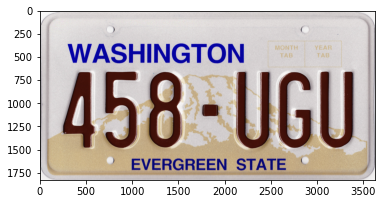

In [9]:
## read image
img = cv2.imread(imgPath)
plt.imshow(img)

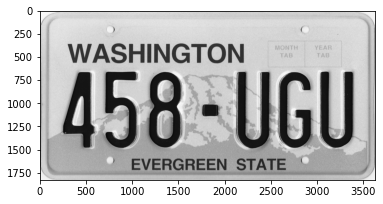

In [10]:
# convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap="gray")

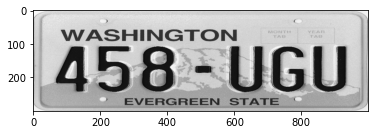

In [11]:
# resize to 300 x 1000 (targetX and targetY)
gray = cv2.resize(gray, (targetY,targetX), interpolation = cv2.INTER_CUBIC)
grayX, grayY = gray.shape
plt.imshow(gray, cmap="gray")

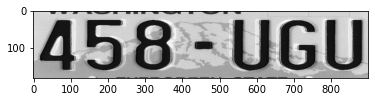

In [12]:
##select from resized gray to remove state and other unnecessary info
gray = gray[int(xTop*grayX):int(xBottom*grayX), int(yLeft*grayY):int(yRight*grayY)]
plt.imshow(gray, cmap="gray")

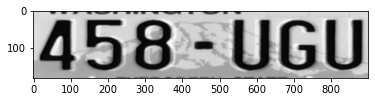

In [13]:
## get blurred image 
gaussianX=7
gaussianY=7
blur = cv2.GaussianBlur(gray,(gaussianX,gaussianY),0)
plt.imshow(blur, cmap="gray")

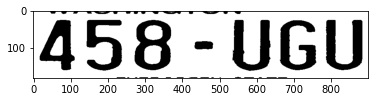

In [14]:
# binarize image and flip blackbackground to whitebackground if needed
ret, thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
if not isWhiteBackground(thresh):
    thresh = 255 - thresh
plt.imshow(thresh, cmap="gray")

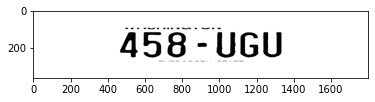

In [15]:
# add patch the surroundings to make the text in the center
threshX, threshY = thresh.shape
extendedThresh = np.full((2*threshX, 2*threshY), 255, dtype="uint8")
extendedThresh[threshX//2:threshX//2+threshX, threshY//2:threshY//2+threshY] = thresh
plt.imshow(extendedThresh, cmap="gray")

In [16]:
plate = ""

## reading from the thresh image as a whole using pytesseract
text = pytesseract.image_to_string(extendedThresh, config = "--psm 13 --oem 3 -c tessedit_char_whitelist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'").split("\n")
if len(text)>1:
    plate = text[0]
print(plate)

458UU


In [17]:
print("Start to use ROI method")

## create folder to store ROI.
## folder is under /result/generatedROI/Washington/0aa2384886a793
generatedROIBasePath = basePath+"/generatedROI/"+state
if not os.path.exists(os.path.dirname(generatedROIBasePath)):
    os.mkdir(os.path.dirname(generatedROIBasePath))
if not os.path.exists(generatedROIBasePath):
    os.mkdir(generatedROIBasePath)
generatedROIPath = generatedROIBasePath+"/"+imageId
if not os.path.exists(generatedROIPath):
    os.mkdir(generatedROIPath)
clearContentsInDirectory(generatedROIPath)

Start to use ROI method


In [18]:
## generate ROI
mask = np.zeros(extendedThresh.shape, dtype=np.uint8)
cnts = cv2.findContours(extendedThresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
(cnts, _) = contours.sort_contours(cnts, method="left-to-right")
cnts = list(cnts)
cnts.sort(key=lambda x:get_contour_precedence(x, extendedThresh.shape[1]))
ROI_number = 0
for c in cnts:
    area = cv2.contourArea(c)
    x,y,w,h = cv2.boundingRect(c)
    if w>30 and h>30 and area<150000:
        ROI =  extendedThresh[y:y+h, x:x+w] 
        if isValidROI(ROI):
            cv2.drawContours(mask, [c], -1, (255,255,255), -1)
            cv2.imwrite(generatedROIPath + "/ROI_{}.png".format(ROI_number), ROI)
            ROI_number += 1

This ROI has char: 4
This ROI has char: 5
This ROI has char: 8
This ROI has char: U
This ROI has char: G
This ROI has char: U
Plate is: 458UGU


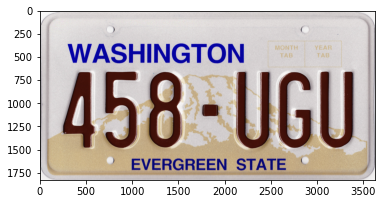

In [19]:
# read from each ROI
plate = ""
targetRoiX, targetRoiY = 80,50
for i in range(ROI_number):
    roi = cv2.imread(generatedROIPath+ "/ROI_{}.png".format(i))
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    roiX, roiY = roi.shape
    extendedRoi = np.full((int(1.5*roiX), int(1.5*roiY)), 255, dtype="uint8")
    extendedRoi[roiX//4:roiX//4+roiX, roiY//4:roiY//4+roiY] = roi
    extendedRoiX, extendedRoiY = extendedRoi.shape
    extendedRoiResize = cv2.resize(extendedRoi, (targetRoiY, targetRoiX), interpolation = cv2.INTER_CUBIC)
    text = pytesseract.image_to_string(extendedRoiResize,lang='eng', config = "--psm 13 --oem 3 -c tessedit_char_whitelist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'")
    if len(text)>1:
        plate = plate + text[0]
        print("This ROI has char: " + text[0])
print("Plate is: " + plate)
plt.imshow(img)